## Tutorial 13. Data wrangling: Reproducing the y-ome paper 

Created by Emanuel Flores-Bautista 2019  All content contained in this notebook is licensed under a [Creative Commons License 4.0 BY NC](https://creativecommons.org/licenses/by-nc/4.0/). The code is licensed under a [MIT license](https://opensource.org/licenses/MIT).

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import numba
import TCD19_utils as TCD

TCD.set_plotting_style_2()

%matplotlib inline
# This enables high res graphics inline
%config InlineBackend.figure_format = 'svg'

This tutorial is based on the [Ghatak *et al.* paper ](https://academic.oup.com/nar/article/47/5/2446/5304327) titled "The y-ome defines the 35% of Escherichia coli genes that lack experimental evidence of function". The authors have [posted all of the code for the analysis on Github](https://github.com/zakandrewking/y-ome) and is a perfect example of reproducible research. It even has a [binder container](https://mybinder.org/v2/gh/zakandrewking/y-ome/master?urlpath=lab/tree/notebooks) to reproduce the code on the cloud.  

Their goal was to get a better understanding of the genes in the *E.coli* genome that haven't been experimentally tested and thus lack annotation. These genes are very important because they have been kept in evolutionary time because most likely because they generate a function in cell phenotype. As the authors note, these argument is evident when thinking of [syn3.0, the third version of a synthetic bacterial cell](https://www.jcvi.org/first-minimal-synthetic-bacterial-cell) created in the John Craig Venter institute. This minimal cell contains only essential genes, of which more than 20% lack functional annotation with current computational methods.

They found that the genes that lack experimental evidence (the "y-ome") have on average, lower expression levels and are enriched in the termination region of the *E. coli* chromosome. The latter observation is related to the nature of DNA replication in *E. coli* but that's another story. 

In this tutorial, we will assess if the first finding of the authors extend to the experimental and hypothetical TFs of *E. coli*, using the data from a paper I worked on during my thesis. 

The workflow is as follows: 

> ###### We will extract the data from the y-ome paper and add the annotation for the TFs using pandas, and then, we will visualize the results using Seaborn. 

### Load y-ome data

In [11]:
path = '../data/'

#Load proteomics dataset
prot= pd.read_csv(path +'proteomics.csv')

#Load RNA-seq dataset
trans = pd.read_csv(path +'tpm-log.tsv', sep = '\t')

#Load yome genes
yome_genes= pd.read_csv(path +'yome-genes.csv')

yome_genes = yome_genes[['locus_tag', 'annotation_quality']]

In [12]:
yome_genes.head()

,locus_tag,annotation_quality
0,b0001,high
1,b0002,high
2,b0003,high
3,b0004,high
4,b0005,low


In [13]:
trans.tail(3)

,locus_tag,base__wt_glc__1,base__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,...,ssw__xyl_ale1__1,ssw__xyl_ale2__1,ssw__xyl_ale3__1,ssw__glc_ac_ac2__1,ssw__glc_ac_glc1__1,ssw__glc_ac_glc2__1,ssw__glc_glyc_glc__1,ssw__glc_glyc_glyc__1,ssw__glc_xyl_glc__1,ssw__glc_xyl_xyl__1
4382,b4705,6.191103,4.742709,1.117788,1.150404,4.719827,4.210143,2.159386,1.045927,2.78746,...,5.00737,5.678765,6.05452,5.676518,0.0,3.716447,5.522589,5.583968,2.048961,5.610336
4383,b4706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4384,b4708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


### Calculate mean log(TPM) values for all of the genes in the Ghatak dataset.

Because genes are in the rows of the dataset, we will have to transpose the dataframe and then apply the mean method, which computes the sample mean of all the columns in a dataframe. 

In [14]:
#Transpose RNAseq dataset
trans_T = trans.iloc[:, 1:].T

In [15]:
trans_T.head()

,0,1,2,3,4,5,6,7,8,9,...,4375,4376,4377,4378,4379,4380,4381,4382,4383,4384
base__wt_glc__1,7.620278,11.005122,10.414124,10.593341,6.314589,6.914252,3.519479,11.185218,6.160173,5.400341,...,2.702842,0.0,2.645214,3.083373,0.000000,3.627100,0.0,6.191103,0.0,0.0
base__wt_glc__2,7.305297,11.128891,10.521833,10.723757,6.257210,6.896302,3.506103,11.213508,6.274033,5.402290,...,2.384966,0.0,2.544366,3.146872,0.000000,0.000000,0.0,4.742709,0.0,0.0
fur__wt_dpd__1,0.000000,11.704301,11.423184,10.456620,5.421493,6.775000,3.640690,11.055138,6.363758,4.283858,...,2.860703,0.0,3.761808,3.901343,0.000000,0.000000,0.0,1.117788,0.0,0.0
fur__wt_dpd__2,1.751335,11.887510,11.803075,10.778455,5.335431,6.781904,3.498010,10.798032,6.329465,4.126895,...,2.912517,0.0,3.638698,3.997067,1.071194,0.000000,0.0,1.150404,0.0,0.0
fur__wt_fe__1,4.400754,11.063797,10.775972,10.393959,6.715066,6.760810,3.290939,10.957334,5.955160,4.868907,...,1.465933,0.0,2.063764,2.638256,2.042979,1.896753,0.0,4.719827,0.0,0.0


In [16]:
#Get mean values for all the genes
mean = trans_T.mean()

In [17]:
#Make a new dataframe for visualization
tpm_log_mean = pd.DataFrame({'mean_log_tpm': mean, 'locus_tag': trans.locus_tag})

In [18]:
tpm_log_mean.head()

,locus_tag,mean_log_tpm
0,b0001,2.268465
1,b0002,10.129340
2,b0003,9.779860
3,b0004,9.672884
4,b0005,5.331030


In order to visualize the $log(TPM)$ distribution of the *E.coli* by annotation, we need to merge the `yome_genes`dataframe with `tpm_log_mean`. In tutorial 2, we learned that we can do this operation with the `pd.merge` function. 

In [19]:
tpm_log_yome = pd.merge(tpm_log_mean, yome_genes, on = "locus_tag")

In [20]:
tpm_log_yome.shape

(4257, 3)

In [21]:
tpm_log_yome.head(3)

,locus_tag,mean_log_tpm,annotation_quality
0,b0001,2.268465,high
1,b0002,10.129340,high
2,b0003,9.779860,high


In [22]:
#Rename column for plotting
tpm_log_yome = tpm_log_yome.rename(columns= {'mean_log_tpm': '$log_{10}(TPM)$'})

In [23]:
tpm_log_yome.head()

,locus_tag,$log_{10}(TPM)$,annotation_quality
0,b0001,2.268465,high
1,b0002,10.129340,high
2,b0003,9.779860,high
3,b0004,9.672884,high
4,b0005,5.331030,low


Now we are ready to visualize the results from the Ghatak paper. Let's visualize the distributions using a violinplot. 

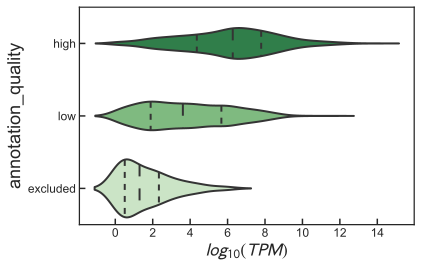

In [24]:
sns.violinplot(data = tpm_log_yome, 
              x = '$log_{10}(TPM)$', 
              y = 'annotation_quality', inner = 'quartile', palette = 'Greens_r');

Awesome! Indeed, we can see that the median of the log(TPM) distribution of the genes with high quality annotation is nearly two orders of magnitude bigger than those with low annotation (y-ome)! Now we can go ahead and test if the same observation holds for transcription factors only. 

*yome ECDF figure*

### Load *E. coli* gene names and locus tags

First, let's load the *E. coli* gene names and locus tags.

In [27]:
ecoli_gene_names = pd.read_csv(path + 'ecoli_genes_locus.csv')

ecoli_gene_names.head()

,locus_tag,gene_name
0,b2353,tfaS
1,b4584,rpnD
2,b3328,gspG
3,b1001,yccE
4,b2467,nudK


### Load TF gene names from RegulonDB

Now we can go ahead and load the TF gene names. This dataset was downloaded from [RegulonDB](http://regulondb.ccg.unam.mx/menu/download/datasets/index.jsp). 

In [28]:
col_names = ['ID','TF', 'gene_name', 'act_conf', 'inact_conf',
             'evidence', 'PMID', 'confidence']

df_TFs = pd.read_csv(path + 'TFSet.txt', comment = '#', delimiter= '\t', 
                  names = col_names)

In [29]:
df_TFs.head(2)

,ID,TF,gene_name,act_conf,inact_conf,evidence,PMID,confidence
0,ECK120015994,AcrR,acrR,AcrR,AcrR-Proflavin|AcrR-R6G|AcrR-ethidium,"[GEA|W|Gene expression analysis], [IMP|W|Infer...",8821940,Strong
1,ECK120012595,Ada,ada,Ada|Ada-Methylated,NaN,"[IDA|S|Inferred from direct assay], [IMP|W|Inf...","11284682, 15305584, 15305585, 16452614, 199519...",Strong


Great! We now have to extract the gene names, and make them lower case in order to make them readily comparable to the Ghatak et al. datasets.

In [30]:
#Extract TF gene names and make them lower case
tf_genes_names = df_TFs['gene_name'].values

tf_genes_names_l = [str(x).lower() for x in tf_genes_names]

In [31]:
len(tf_genes_names_l)

215

Notice that this dataset only contains 215 TFs. 

### Load Pérez-Rueda lab hypothetical TF list

Now, we are going to load the hypothetical TFs found by my lab.

In [32]:
#Load Pérez-Rueda lab hyp TF list 

path = '../data/'
hyp_tf_genes = pd.read_csv(path + 'hypTF_list_genes.csv')

# Extract hyp TF gene names as a numpy array
hyp_tf_gene_names = hyp_tf_genes['hyptfs'].values

hyp_tf_gene_names.shape

(102,)

### Extract hypothetical and experimental TF locus tags

In [33]:
#Extract experimental TFs list 
#Experimental TFs will be those genes annotated by RegulonDB
#that do not appear in the hypTF list from the Perez Rueda Lab

TFs_annot = []

for gene in ecoli_gene_names['gene_name']:
    if gene.lower() in tf_genes_names_l and gene not in hyp_tf_gene_names:
        TFs_annot.append('exp')
    
    elif gene.lower() in hyp_tf_gene_names:
        
        TFs_annot.append('hyp')
        
    else:
        TFs_annot.append('non_TF_protein')
                 

ecoli_gene_names['annot'] = TFs_annot

In [34]:
ecoli_gene_names.tail()

,locus_tag,gene_name,annot
4598,b4499,yehH,non_TF_protein
4599,b0235,ykfJ,non_TF_protein
4600,b4524,ymjB,non_TF_protein
4601,b4308,yjhR,non_TF_protein
4602,b4631,ykgQ,non_TF_protein


In [35]:
hyp = ecoli_gene_names[ecoli_gene_names['annot'] == 'hyp']

exp = ecoli_gene_names[ecoli_gene_names['annot'] == 'exp']

nonTF = ecoli_gene_names[ecoli_gene_names['annot'] == 'non_TF_protein']

#Extract TFs locus tags for each group
hyp_locus_tags =  hyp['locus_tag'].values

exp_locus_tags =  exp['locus_tag'].values

### Add TF annotation to the Ghatak *et al.* datasets

We now just have to add the TF annotation to the `tpm_log_yome`dataframe and we can visualize the results.

In [36]:
tf_annot = []

for row in tpm_log_yome['locus_tag']:
    
    if row in exp_locus_tags :
        tf_annot.append('exp')
    elif row in hyp_locus_tags:
        
        tf_annot.append('hyp')
        
    else:
        tf_annot.append('non_TF') 
        
tpm_log_yome['TF_annotation'] = tf_annot

In [37]:
tpm_log_yome.tail()

,locus_tag,$log_{10}(TPM)$,annotation_quality,TF_annotation
4252,b4702,0.843172,high,non_TF
4253,b4703,0.393040,low,non_TF
4254,b4705,2.591545,low,non_TF
4255,b4706,0.000000,low,non_TF
4256,b4708,0.000000,high,non_TF


Finally, we can go ahead and plot the $log(TPM)$ distributions with the TF annotation. 

In [38]:
ch = sns.cubehelix_palette(n_colors = 3, reverse = True)

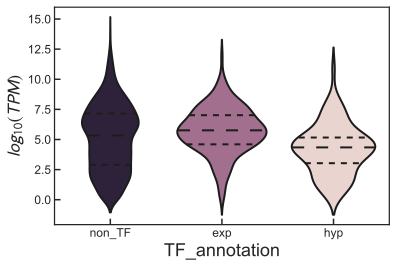

In [39]:
sns.violinplot(data = tpm_log_yome, y = '$log_{10}(TPM)$', x ='TF_annotation', 
              palette = ch, inner = 'quartile');

cool! Indeed, transcription factors with low quality annotation or hypothetical TFs, have lower expression levels than those with experimental validation. Another interesting thing to notice is that TFs in general, have lower expression levels than other proteins in *E. coli*. 

*schmidt figure*

In [40]:
from scipy.stats import ttest_ind

In [41]:
hyp_mean_TPM = tpm_log_yome[tpm_log_yome['TF_annotation'] == 'hyp']['$log_{10}(TPM)$'].values
exp_mean_TPM = tpm_log_yome[tpm_log_yome['TF_annotation'] == 'exp']['$log_{10}(TPM)$'].values

Now, we can test if the difference of means in both distributions (hypothetical vs experimentally validated TFs) is statistically significant. 

In [42]:
#Run one side t-test
ttest_ind(hyp_mean_TPM, exp_mean_TPM)

Ttest_indResult(statistic=-5.705659491663801, pvalue=3.1047195576738605e-08)

You can even go further and make a bootstrap test for the difference of medians.

In [43]:
#write your code here. 

### Extending the analysis: from the transcriptome to the proteome. 

Despite not shown in their paper, the Palsson group also extended their analysis to the protein copy number levels. Quite naturally, we would expect that the differences would only amplify at the level of proteins, but let's wait and see if this difference between expression level holds. 

In [44]:
prot.head(2)

,Unnamed: 0,Unnamed: 0.1,Uniprot Accession,Description,primary_name,Peptides.used.for.quantitation,Confidence.score,Molecular weight (Da),Dataset,Glucose,...,42°C glucose,pH6 glucose,Xylose,Mannose,Galactose,Succinate,Fructose,locus_tag,annotation_quality,mean_log_val
0,0,0,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=E...,rpoC,91,6045.53,155045.0080,2,2779,...,3985,3339,3632.0,3401.0,2258,2764,4517.0,b3988,high,11.614570
1,1,1,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Es...,rpoB,89,5061.29,150520.2758,2,3957,...,4923,4032,4437.0,4143.0,2820,3855,5269.0,b3987,high,11.926349


In [45]:
prot_yome = prot.merge(yome_genes)

In [46]:
yome_genes.head()

,locus_tag,annotation_quality
0,b0001,high
1,b0002,high
2,b0003,high
3,b0004,high
4,b0005,low


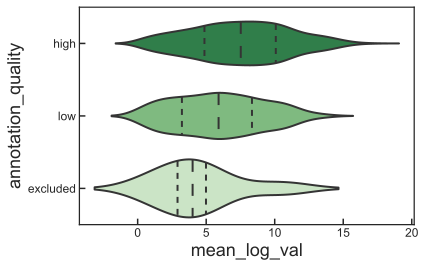

In [48]:
sns.violinplot(data = prot_yome, x = 'mean_log_val', y = 'annotation_quality',
           palette = 'Greens_r', inner = 'quartile')

#plt.savefig('../Desktop/yome_prot_cel.png', dpi = 420)

Voilà!

In [49]:
tf_annot = []

for row in prot_yome['locus_tag']:
    if row in exp_locus_tags :
        tf_annot.append('exp')
    elif row in hyp_locus_tags:
        
        tf_annot.append('hyp')
        
    else:
        tf_annot.append('non_TF') 
        
prot_yome['TF_annotation'] = tf_annot

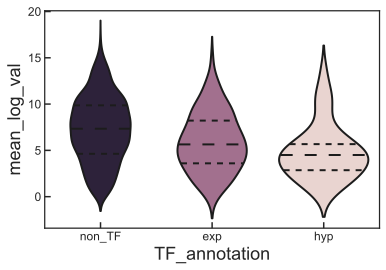

In [50]:
sns.violinplot(data = prot_yome, y = 'mean_log_val', x ='TF_annotation', 
              palette = ch, inner = 'quartile');


### Challenge. 

Calculate the effect size (Cohen's d), and run bootstrap tests on this measurement for the hypothetical and experimental TFs in both the transcriptome and proteome levels. 